In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import py_fort_myrmidon as fm
import datetime
import networkx as nx
import community
import statistics
import scipy.stats as stats
from os import listdir
from datetime import datetime, date, timedelta
import pickle

In [2]:
working_dir = '/media/eg15396/EG_DATA-7/NTM/'
myrm_list = sorted([ s for s in listdir(working_dir) if s[15:17] == '.m'])

In [14]:
# function to compute netowrk properties
def G_prop(G, start, time_win, max_gap, name):
    
    # compute connencted components
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    GC = G.subgraph(Gcc[0])
    
    # Best partition Louvian Method
    best_partition = community.best_partition(GC, weight='weight', randomize=False)
    return {'rep': int(name[8:10]),
            'exp': name[11:15],
            'start': fm.Time.ToDateTime(start), 
            'time_win': time_win, 
            'max_gap': max_gap,
            'CC': len(Gcc),
            'ants': G.number_of_nodes(),
            'partition': np.max(list(best_partition.values())) + 1,
            'MOD': community.modularity(best_partition, GC), 
            'DEN': nx.density(GC), 
            'wDEN': nx.adjacency_matrix(G).sum() / (G.number_of_nodes() * (G.number_of_nodes() - 1) * time_win),  # weighted density = sum all weights /(|V|*(|V|-1)/2 * time_win)
            'DIA': nx.diameter(GC),
            'wDIA': nx.diameter(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'RAD': nx.radius(GC),
            'wRAD': nx.radius(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'DEH': np.std([GC.degree(n) for n in GC.nodes()]),
            'wDEH': np.std(nx.adjacency_matrix(G).sum(axis=0)), # strength heterogeneity
            'CLS': np.mean([c for c in nx.clustering(G, weight='weight').values()]) 
            }

# initialise data-frame with properties
prop_df = pd.DataFrame(columns=G_prop(nx.Graph(np.eye(2)),fm.Time.Now(),1,1,myrm_list[0]).keys())

In [86]:
# Function to compute the cumulative interaction function
def compute_G(exp, start, end, min_cum_duration, frm_rate):
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}

    # Populate network
    for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                            reportFullTrajectories= False)[1]:
        
        # Focus on Nest zone (id=1)
        if not(0 in i.Trajectories[1].Zones):
                
            # OPT1
            # WEIGHTS: cumulative interaction time
            adj_mat[i.IDs[0]-1, i.IDs[1]-1] += (TimeToFrame[fm.Time.ToTimestamp(i.End)] - TimeToFrame[fm.Time.ToTimestamp(i.Start)]) * 1 / frm_rate
        
            # OPT2
            # WEIGHTS: number of interactions
            #adj_mat[i.IDs[0]-1, i.IDs[1]-1] += 1
                    

    # interaction filtering (remove weak connections)
    adj_mat[adj_mat <  min_cum_duration] = 0

    # network build
    G = nx.Graph(adj_mat)

    # store inverse of weights
    nx.set_edge_attributes(G, 
                           {(i,j): 1/adj_mat[j,i] if adj_mat[j,i]>0 else 0 for i in range(len(adj_mat)) for j in range(i)},
                           'inv_weight')
    return G



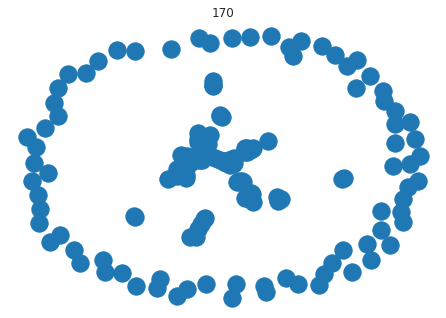

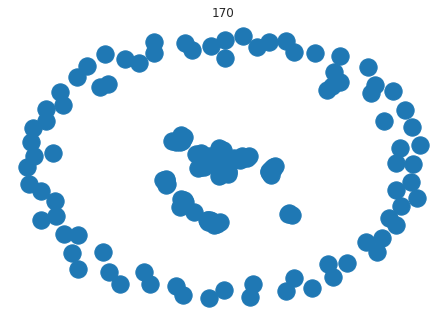

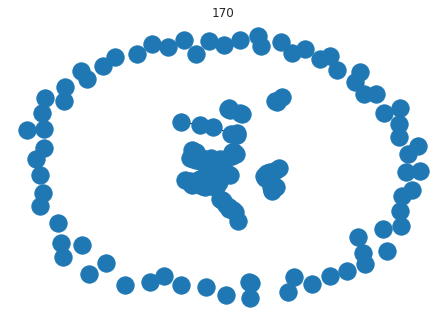

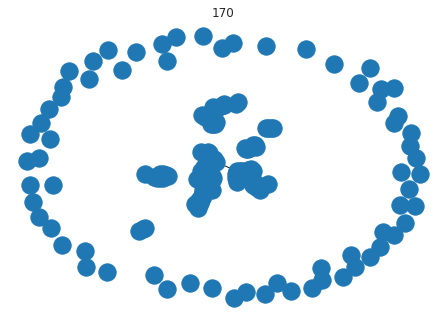

In [91]:
# Zooning TEST
myrm_file = myrm_list[-2]


exp = fm.Experiment.Open(working_dir + myrm_file)
start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
             timedelta(days = -1)).strftime("%Y-%m-%d")

# ======== 12H window ========

# cumulative time window (s)
time_win = 60 * 0.5

for t in range(4):
    start_g = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  #to do: double check time shift
    start = start_g.Add(fm.Duration(t * time_win * 10**9))
    end = start.Add(fm.Duration(time_win * 10**9))
    

    N_ants = len(exp.Ants)

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    #TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}
    Q_int = fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(10*10**9),
                                            reportFullTrajectories= False)
    G = compute_G(exp, start, end, min_cum_duration, frm_rate)


    # compute connencted components
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    GC = G.subgraph(G)
    
    plt.figure()
    nx.draw(GC)
    plt.title(GC.number_of_nodes())

In [16]:
## ========= PARAMETERS========= 
# Frame rate
frm_rate = 6

# maximum gap (s) for interaction computation
for max_gap in [5,10,20]:

    print(max_gap)
    
    # minimum cumulative interaction duration (s)
    min_cum_duration = 0 


    ## ============================ 


    for myrm_file in myrm_list[20:]:
        
        if int(myrm_file[8:10])==41: 
            continue

        print(myrm_file)

        # Open experiment file
        exp = fm.Experiment.Open(working_dir + myrm_file)


        ## ------ Time window ------ 
        # define time window of cumulative network
        start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                     timedelta(days = -1)).strftime("%Y-%m-%d")


        # ======== 12H window ========
        print('12h slot')
        # cumulative time window (s)
        time_win = 60 * 60 * 12

        start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  #to do: double check time shift
        end = start.Add(fm.Duration(time_win * 10**9))

        # Compute network
        G = compute_G(exp, start, end, min_cum_duration, frm_rate)

        # Compute properties
        prop_df = prop_df.append(G_prop(G, start, time_win, max_gap, myrm_file), ignore_index=True)

        # ======== 1H window ========
        time_win = 60 * 60 * 1
        for tw in range(12):
            print('1h slot ' + str(tw + 1))
            s = start.Add(fm.Duration(tw * time_win * 10**9))
            e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

            # Compute network
            G = compute_G(exp, s, e, min_cum_duration, frm_rate)

            # Compute properties
            prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
            
            
        
        # ======== 2H window ========
        time_win = 60 * 60 * 2
        for tw in range(6):
            print('1h slot ' + str(tw + 1))
            s = start.Add(fm.Duration(tw * time_win * 10**9))
            e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

            # Compute network
            G = compute_G(exp, s, e, min_cum_duration, frm_rate)

            # Compute properties
            prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
            
            

        # ======== 4H window ========
        time_win = 60 * 60 * 4
        for tw in range(3):
            print('4h slot ' + str(tw + 1))
            s = start.Add(fm.Duration(tw * time_win * 10**9))
            e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

            # Compute network
            G = compute_G(exp, s, e, min_cum_duration, frm_rate)

            # Compute properties
            prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)



# Save
a_file = open("data/prop_data_gap_12_4_2_1_ct_NEST.pkl", "wb")
pickle.dump(prop_df, a_file)
a_file.close()

prop_df

    


10
EG_NTM_s31_DEHa.myrmidon
12h slot


AttributeError: 'py_fort_myrmidon.AntTrajectorySegment' object has no attribute 'Zones'

In [258]:
# Open Pickle data

a_file = open("data/prop_data_12h_4h.pkl", "rb")
df = pickle.load(a_file)
df

,rep,exp,start,time_win,CC,ants,partition,MOD,DEN,wDEN,DIA,wDIA,RAD,wRAD,DEH,wDEH,CLS
0,13,DEHa,2021-09-12 09:00:00,43200,1,177,3,0.265934,0.964432,0.004569,2,0.005756,1,0.003515,7.920525,11376.651457,0.017645
1,13,DEHa,2021-09-12 09:00:00,14400,1,177,4,0.314675,0.805727,0.004812,2,0.013881,1,0.008613,22.507434,4459.552219,0.006845
2,13,DEHa,2021-09-12 13:00:00,14400,1,177,5,0.288999,0.79218,0.004316,2,0.018524,1,0.009419,24.481888,4023.410278,0.010674
3,13,DEHa,2021-09-12 17:00:00,14400,1,177,4,0.293203,0.810927,0.004576,2,0.013834,1,0.008749,23.435623,4643.090357,0.005611
4,13,DEHb,2021-09-10 09:00:00,43200,1,186,3,0.24222,0.966289,0.005501,2,0.005506,1,0.003833,8.186532,17266.894913,0.019331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,56,DENa,2021-12-22 17:00:00,14400,1,170,6,0.303259,0.785103,0.00719,2,0.012147,1,0.006513,25.351511,5673.870481,0.012476
348,56,DENb,2021-12-20 09:00:00,43200,1,172,3,0.18531,0.98504,0.007974,2,0.00402,1,0.002479,4.145899,14897.345335,0.04447
349,56,DENb,2021-12-20 09:00:00,14400,1,172,5,0.242208,0.832041,0.008077,2,0.009572,1,0.006048,21.701276,5845.620486,0.017827
350,56,DENb,2021-12-20 13:00:00,14400,1,172,5,0.252718,0.830409,0.008147,2,0.00811,1,0.005179,21.781153,5613.886605,0.022328


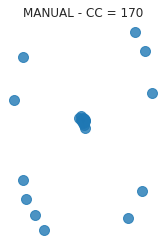

In [62]:

#%% PLOTTING network comparison
# starting node position for spring layout
sns.set(font_scale = 1)
plt.figure()
start_pos = nx.random_layout(G)

# manual 
pos = nx.spring_layout(G,  iterations=100, pos=start_pos)
ax = plt.subplot(121)
nx.draw(G, ax=ax, pos=pos, node_size=1*100, alpha=0.8)
p = plt.title('MANUAL - CC = ' +str(len(G)))
